In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch

from src.models.unet import UNet
from src.config import SEED, DEVICE
from src.utils.random import set_seed
from src.utils.visualisations import plot_pre_post_mask
from src.unet.unet_train import get_model
from src.utils.segmentation_train import get_dataloaders
from src.utils.parser import get_config

DATA_PATH = '../data/'
MODELS_PATH = f'{DATA_PATH}models/'
BATCH_SIZE = 1

set_seed(SEED)

In [3]:
config = get_config("../config/unet_best_params.yml")
encoder_channels = config["encoder_channels"]
decoder_channels = config["decoder_channels"]
dropout_rate = float(config["dropout_rate"])
loss_name = config["loss_name"]
learning_rate = float(config["learning_rate"])
weight_decay = float(config["weight_decay"])
accumulation_steps = int(config["accumulation_steps"])
evaluation_steps = int(config["evaluation_steps"])
use_scaler = bool(config["use_scaler"])
epochs = int(config["num_epochs"])

In [4]:
model_save_dict = f'{MODELS_PATH}unet/'
model_save_path = sorted(os.listdir(model_save_dict))[-1]
model_save_path = f'{model_save_dict}{model_save_path}'
model = get_model(
    encoder_channels=encoder_channels,
    decoder_channels=decoder_channels,
    dropout_rate=dropout_rate,
)
print('✅ Using model at ', model_save_path)
model.load_state_dict(torch.load(model_save_path))
model.eval()

train_loader, val_loader, test_loader = get_dataloaders(BATCH_SIZE)

✅ Using model at  ../data/models/unet/20231224-153605_UNet_AdamWoptim_100epochs_4e-05lr_DiceLossloss_ReLUact_001dropout_1accstep_100evalstep_18encchan_18decchan.pth
✅ Train dataloader length: 133
✅ Test dataloader length: 28
✅ Val dataloader length: 29


In [5]:
# Load train example
train_it = iter(train_loader)

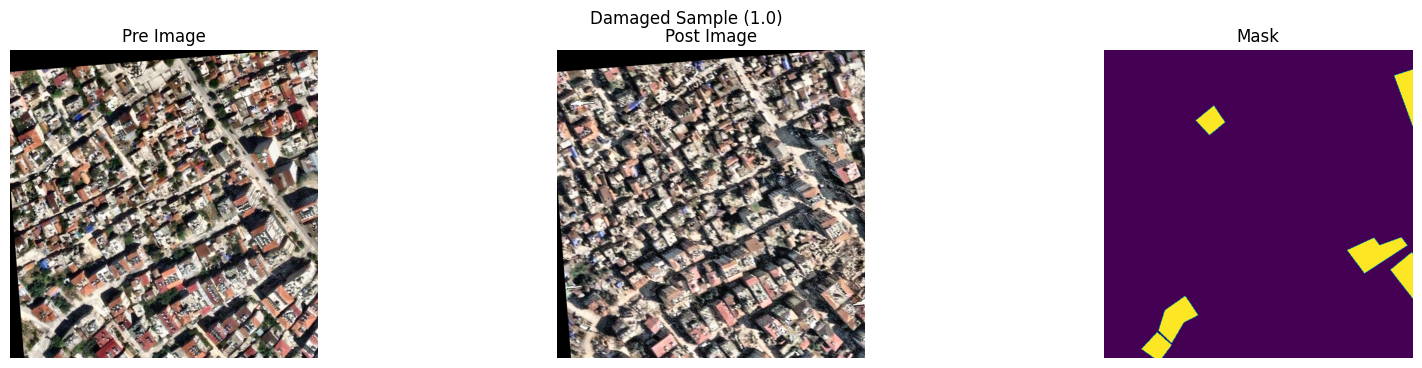

In [6]:
pres, posts, masks, labels = next(train_it)

pre = pres[0]
post = posts[0]
mask = masks[0]
label = labels[0]

plot_pre_post_mask(pre, post, mask, label, is_normalised=True)

In [38]:
# Load validation example
it = iter(test_loader)

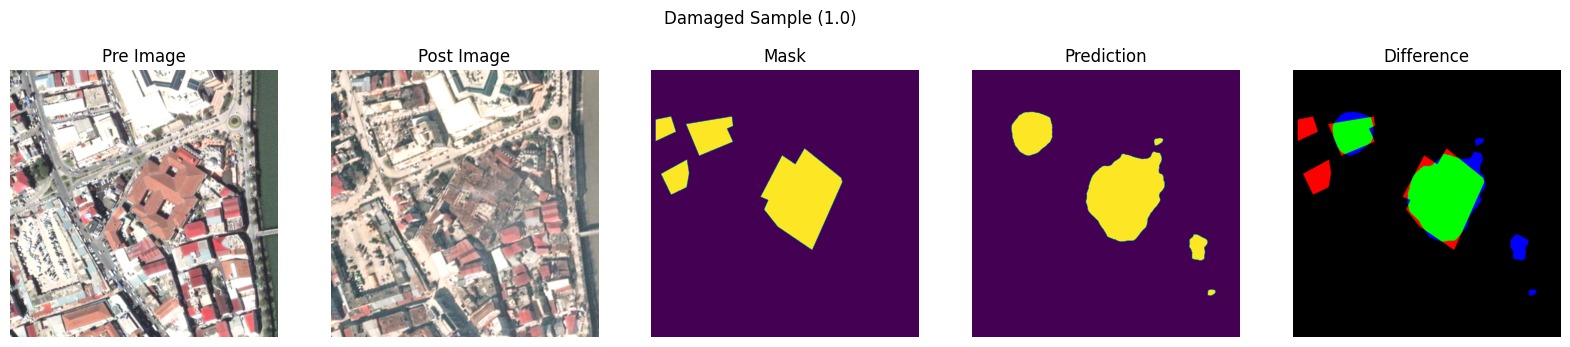

In [49]:
pres, posts, masks, labels = next(it)

pre = pres[0].unsqueeze(0).to(DEVICE)
post = posts[0].unsqueeze(0).to(DEVICE)
mask = masks[0].cpu()
label = labels[0]

# Get Prediction
pred = model(pre, post).squeeze()
pred = torch.nn.Sigmoid()(pred).cpu().detach()
pred = (pred > 0.5).float()

# Plot example
pre = pre.squeeze(0).cpu().detach()
post = post.squeeze(0).cpu().detach()
plot_pre_post_mask(pre, post, mask, label, pred=pred, is_normalised=True)